# LLM-powered Clickbait Detector - Part 1

The aim of this project is to classify an article headline as either safe/unsafe and clickbait/non-clickbait using LLMs

In [1]:
# read data
import pandas as pd
df = pd.read_csv('data_folder/clickbait_data.csv')
df.head()

,headline,clickbait
0,Should I Get Bings,1
1,Which TV Female Friend Group Do You Belong In,1
2,"The New ""Star Wars: The Force Awakens"" Trailer...",1
3,"This Vine Of New York On ""Celebrity Big Brothe...",1
4,A Couple Did A Stunning Photo Shoot With Their...,1


### Exploratory Analysis

In [2]:
# check data info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32000 entries, 0 to 31999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   headline   32000 non-null  object
 1   clickbait  32000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 500.1+ KB


From the `df.info()` output, we see that the data contains two columns - headline and clickbait. For the clickbait column,  we have two classes - clickbait and Non-clickbait, represented as 1 and 0 respectively. Next,check if the classes in data contain missing/null values

In [3]:
#check if any of the columns hvae missing/null values
df.isnull().sum()

headline     0
clickbait    0
dtype: int64

From the above output, it is clear that the each class in the data contains no missing/null values in the columns. Next, we check the distribution of each class in the data. 

In [4]:
# distribution of each class
df['clickbait'].value_counts()

clickbait
0    16001
1    15999
Name: count, dtype: int64

We see that we have a balanced data, i.e., relatively equal number of entries for each class - clickbait(15999) and non-clickbait(16001). 

### LLM-powered Clickbait Detector
We have performed some exploratory data analysis and so far, this is sufficient for us to proceed into building an LLM-powered clickbait detector. For this project, we will leverage on OpenAI's `gpt-3.5-turbo` as our LLM and use `Comet ML` and `Comet LLM` for logging, tracking and debugging our prompts and results. First we have to install the environment requirements and import the neccsary libraries. 

In [5]:
# install requirements
! pip3 install openai==0.28 transformers[torch] comet-ml comet-llm datasets evaluate sentencepiece --quiet tensorflow==2.15 accelerate==0.27.0 scikit-learn

You should consider upgrading via the '/Users/Tolu/llmops/venv/bin/python3 -m pip install --upgrade pip' command.


In [6]:
# import required libraries
import openai
import os
import IPython
import pandas as pd
import numpy as np
import comet_llm
import comet_ml
import pickle
import json
import torch

from transformers import AutoTokenizer
from datasets import load_dataset
import evaluate
from transformers import AutoModelForCausalLM
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer
from transformers import Trainer, TrainingArguments
import transformers
transformers.set_seed(35)
from datasets import Features, Value, Dataset, DatasetDict


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# API configuration
openai.api_key = "YOUR_OPEN_API_KEY"

COMET_API_KEY = "YOUR_COMET_API"
COMET_WORKSPACE = "YOUR_COMET_WORKSPACE"

/Users/Tolu/llmops/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


### Dataset Preparation

The `get_completion` function below enables us to get response from our LLM

In [9]:
# completion function
model = "gpt-3.5-turbo"
def get_completion(messages, model = "gpt-3.5-turbo", temperature=0, max_tokens=300):
    response = openai.ChatCompletion.create(
        model=model,
        messages=messages,
        temperature=temperature,
        max_tokens=max_tokens,
    )
    return response.choices[0].message["content"]

In [8]:
def decode(indices, index_to_class):
    return [index_to_class[index] for index in indices]
    
class_to_index= {'non-clickbait': '0', 'clickbait': '1'}
index_to_class = {v:k for k, v in class_to_index.items()}

### Prompts
Prompts are instructions and context passed to a language model to achieve a desired task. The task for this project is to classify article headlines as clickbait or non-clickbait using LLM. So we have to come up with prompts that can help us achieve this task.  

In [238]:
# prompt test 1 
prompt_prefix = """
Your task is to classify the headline of an article as Clickbait or Non-clickbait. A clickbait is a text designed to attract attention and to entice users to read, view, or listen to the linked piece of content, being typically deceptive, sensationalized, or otherwise misleading. 

Your output tag should be  \'1'\ if the article headline is clickbait  and \'0'\ if it is not clickbait
"""
prompt_suffix = """headline: {Input} \nTags: """


### Prompting Techniques
We considering three prompting techniques:
- Zero-shot: This technique provides the model with the infomation that tells it what task to perform but with no examples.
- Few-shot: This approach involves feeding the LLM model high quality examples to steer its response more effectively.
- Chain-of-Thought: In this approach, we guide the model through series of logical steps.

#### Zero Shot Learning

In [142]:
zero_shot_template = prompt_prefix + prompt_suffix
zero_shot_template 

"\nYour task is to classify the headline of an article as Clickbait or Non-clickbait. A clickbait is a text designed to attract attention and to entice users to read, view, or listen to the linked piece of content, being typically deceptive, sensationalized, or otherwise misleading. \nYour output for should be  '1'\\ for clickbait and '0'\\ for Non-clickbait\nheadline: {Input} \nTags: "

In [144]:
## testing zero-shot
message = [
    {
        "role": "system",
        "content": zero_shot_template.format(Input=df['headline'][21000])
    }
]

response = get_completion(message)
print(response)

0


### Few Shot Context Learning

For few-shot, we show the LLM a few examples of the data

In [146]:
# function to define the few-shot template
def get_few_shot_template(few_shot_prefix, few_shot_suffix, few_shot_examples):

    return few_shot_prefix + "\n\n" + "\n".join([ "headline: "+ few_shot_examples.headline[ex].strip() + "\n" + "Tags: " + str(few_shot_examples.clickbait[ex]) + "\n" for ex in range(len(few_shot_examples))]) + "\n\n" + few_shot_suffix

# function to sample few shot data
def random_sample_data (data, n):
    return data.sample(n, replace=False, ignore_index=True)

# the few-shot prefix and suffix
few_shot_prefix = "Your task is to classify the headline of an article as Clickbait or Non-clickbait. A clickbait is a text designed to attract attention and to entice users to read, view, or listen to the linked piece of content, being typically deceptive, sensationalized, or otherwise misleading." 

few_shot_suffix = prompt_suffix

# load 3 samples from few shot data
few_shot_template = get_few_shot_template(few_shot_prefix, few_shot_suffix, random_sample_data(df, 20))

### Chain of Thought (CoT) prompting technique

In this case, there is a twist to the prompt. we are going to guide the LLM through series of reasoning steps to know whether articles are safe/unsafe and clickbait/not clickbait. To define what safety article should be, we check to see if it contains harmful or misleading information. For example, a news article may be tagged non-clickbait, however the content could be potentially unsafe if the context of the headline seem to carry harmful or misleading information. The goal is to classify article headline as either safe/unsafe and clickbait/non-clickbait. We will guide the LLM through a series of steps to steer its response regarding the task.

In [14]:
cotTemplate = """
Your task is to classify an article into the following tags based on the headline. \n\ntag: ['Clickbait', 'Non-clickbait', 'Safe', 'Unsafe'].

A Clickbait is a text designed to attract attention and to entice users to read, view, or listen to the linked piece of content, being typically deceptive, sensationalized, or otherwise misleading. 

An article is safe if it the information it carries is factually correct, based on data that can be confirmed, not misleading in any way, and does not contain any element of misinformation, disinformation and malinformation. 

Step 1: Check if the article is a Clickbait
Step 2: Check if the article is Safe
step 3: Prepare a response in an array to the user based on <Step 1> and <Step 2> whether the article is safe/unsafe and clickbait/not clickbait.

Return a response with the following reasoning steps to the user:
Step 1: <Step 1 reasoning>
Step 2: <Step 2 reasoning>
Step 3: <final response>


 
headline: {Input} 
Tags: 
 
 """


In [15]:
## testing CoT
message = [
    {
        "role": "system",
        "content": cotTemplate.format(Input="```Experts reveal the truth about eating raw meat.```")
    }
]

response = get_completion(message)
print(response)

Step 1: The headline does not appear to be clickbait as it is straightforward and informative.
Step 2: The article is likely safe as it suggests that experts are providing information about eating raw meat, which can be factually correct and informative.
Step 3: The article is Non-clickbait and Safe.


### Logging Prompt + Results to Comet

The following is a helper function to obtain the final predictions from the model given a prompt template (e.g., zero-shot or few-shot) and the provided input data.

In [16]:
def get_predictions(prompt_template, inputs):

    responses = []

    for i in range(len(inputs)):
        messages = messages = [
            {
                "role": "system",
                "content": prompt_template.format(Input=inputs[i])
            }
        ]
        response = get_completion(messages)
        responses.append(response)

    return responses

In [151]:
# sample articles
articles = df.sample(10,replace=False, ignore_index=True)

#get predictions for the prompting techniques
few_shot_predictions = decode(get_predictions(few_shot_template,articles.headline), index_to_class)
zero_shot_predictions = decode(get_predictions(zero_shot_template, articles.headline), index_to_class)
cot_predictions = get_predictions(cotTemplate, articles.headline)
expected_tags = decode([str(articles["clickbait"][i]) for i in range(len(articles))], index_to_class)

In [41]:
# initialize comet
comet_llm.init(api_key = COMET_API_KEY, workspace = COMET_WORKSPACE, project="clickbait-detector-prompts")

# log the predictions
for i in range(len(expected_tags)):
    # log the few-shot predictions
    comet_llm.log_prompt(
        prompt=few_shot_template.format(Input=articles.headline[i]),
        prompt_template=few_shot_template,
        output=few_shot_predictions[i],
        tags = ["gpt-3.5-turbo", "few-shot"],
        metadata = {
            "expected_tags": expected_tags[i],
            "article": articles.headline[i],
        }
    )

    # log the zero-shot predictions
    comet_llm.log_prompt(
        prompt=zero_shot_template.format(Input=articles.headline[i]),
        prompt_template=zero_shot_template,
        output=zero_shot_predictions[i],
        tags = ["gpt-3.5-turbo", "zero-shot"],
        metadata = {
            "expected_tags": expected_tags[i],
            "article": articles.headline[i],
        }
    )

    # log the CoT predictions
    comet_llm.log_prompt(
        prompt=cotTemplate.format(Input=articles.headline[i]),
        prompt_template=cotTemplate,
        output=cot_predictions[i],
        tags = ["gpt-3.5-turbo", "CoT"],
        metadata = {
            "expected_tags": expected_tags[i],
            "article": articles.headline[i],
        }
    )

COMET INFO: Valid Comet API Key saved in /Users/Tolu/.comet.config (set COMET_CONFIG to change where it is saved).


We have logged our prompts and results to Comet as shown below

<img src="./comet_llm.png" class="bg-primary mb-1" width="1024px">

### Confusion Matrix

Next, we prepare a confusion matrix to better understand the performance of the `few-shot` prompting technique on the classification task.

In [260]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# map labels to integers
label_map = {
    "non-clickbait": 0,
    "clickbait": 1,
}

# mapper back to string labels
label_map_string = {
    0: "non-clickbait",
    1: "clickbait",
}


In [261]:
# sample articles
articles = df.sample(200,replace=False, ignore_index=True)

#get predictions for the prompting techniques
few_shot_predictions = decode(get_predictions(few_shot_template,articles.headline), index_to_class)
expected_tags = decode([str(articles["clickbait"][i]) for i in range(len(articles))], index_to_class)

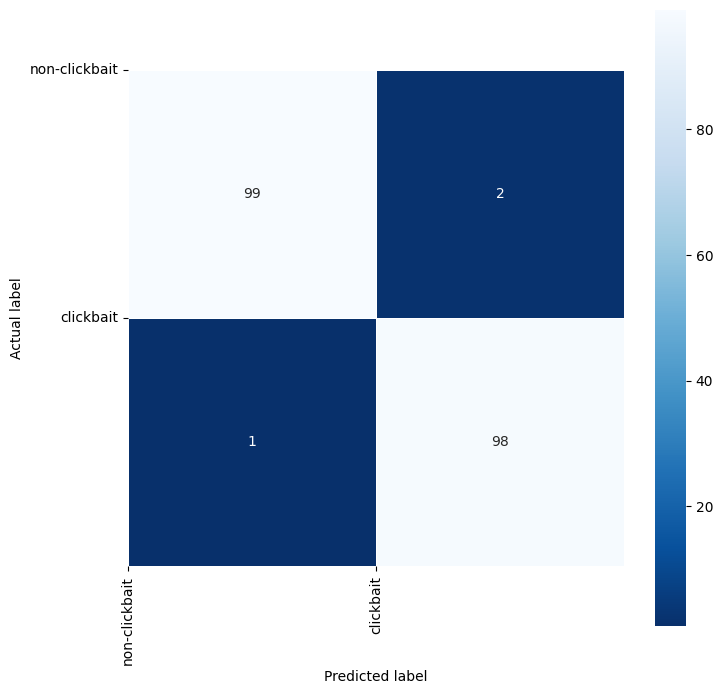

In [268]:
few_shot_predictions_int = pd.Series(few_shot_predictions).map(label_map)
expected_tags_int = pd.Series(expected_tags).map(label_map)

# confusion matrix
cm = confusion_matrix(expected_tags_int,few_shot_predictions_int )

# plot confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=0.5, square=True, cmap="Blues_r")

# add emotion labels to confusion matrix
plt.ylabel("Actual label")
plt.xlabel("Predicted label")

# annotate the confusion matrix with completion labels
tick_marks = [i for i in range(len(label_map_string))]
plt.xticks(tick_marks, list(label_map_string.values()), rotation="vertical")
plt.yticks(tick_marks, list(label_map_string.values()), rotation="horizontal");